# Delimiter Analysis

In [1]:
import sys

sys.path.append("../src")
import train

In [2]:
import torch

RUN = "../runs/nlab-gpt-medium-8.7M-eb4543e4/nlab-gpt-medium-8.7M-eb4543e4-2025-12-16-46500-[best(2.0324)].pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_base = train.Run.from_file(RUN)
run_base.model.to(device)
None  # No output

In [3]:
val_data = torch.load("../data/val_data.pt").to(device)

In [4]:
import collections
import re


class UnbalancedDelimiter(Exception): ...


# Compute the token positions of every balanced delimiters '(' and ')'
# LIMITATION: Weird tokens like "((", "))", ")(" are naively handled.
# def get_delimiters(input_ids, allow_unmatched_opened=True):
#     tokens = [run.tokenizer.decode([i]) for i in input_ids]
#     opened = []
#     pairs = []
#     for n, token in enumerate(tokens):
#         for char in token:
#             match char:
#                 case "(":
#                     opened.append((n, token))
#                 case ")":
#                     if not opened:
#                         raise UnbalancedDelimiter("Found ')' with empty stack")
#                     i, otoken = opened.pop()
#                     # We only push pairs of distinguishable tokens
#                     co, cc = collections.Counter(otoken), collections.Counter(token)
#                     if not any(
#                         t.count("(") + t.count(")") > 1 for t in [otoken, token]
#                     ):
#                         pairs.append((i, n))
#     if not allow_unmatched_opened and opened:
#         raise UnbalancedDelimiter(f"Unmatched '(' remaining: {len(opened)}")
#     return pairs

envname = re.compile(r"^\{[a-zA-Z][a-zA-Z0-9]*\}")


def get_delimiters(input_ids, allow_unmatched_opened=True):
    tokens = [run_base.tokenizer.decode([i]) for i in input_ids]
    opened = []
    pairs = []
    active = False
    for n, token in enumerate(tokens):
        if token.endswith("\\"):
            active = True
            continue
        if active:
            match token:
                case "begin":
                    opened.append(n)
                case "end":
                    if not opened:
                        raise UnbalancedDelimiter("Found '\\end' with empty stack")
                    # TODO Look at what happens if we care about environment names
                    # # If end is not followed by {envname}
                    # # (We look at the next 10 tokens to be large)
                    # if not envname.match("".join(tokens[n + 1 : n + 11])):
                    #     raise UnbalancedDelimiter(
                    #         "Found '\\end' not followed by environment"
                    #     )
                    o = opened.pop()
                    pairs.append((o, n))
            active = False
    if not allow_unmatched_opened and opened:
        raise UnbalancedDelimiter(f"Unmatched '\\begin' remaining: {len(opened)}")
    return pairs


# Generate a batch of sequences with balanced delimiters
# The sequences are not guaranteed to be distinct (or to not overlap)
def get_batch(
    run,
    oversample_factor=8,
    max_rounds=200,
    min_pairs=1,
    allow_unmatched_opened=True,
):
    N = val_data.size(0)
    B = run.config.per_device_train_batch_size
    T = run.config.max_position_embeddings

    ar = torch.arange(T, device=device)[None, :]  # (1, T)

    xs = []
    xpairs = []

    # for _ in range(max_rounds):
    while True:
        K = oversample_factor * (B - len(xs))
        if K <= 0:
            break

        start = torch.randint(0, N - T - 1, (K,), device=device)
        pos = start[:, None] + ar  # (K, T)

        xk = val_data[pos].to(device)  # (K, T)

        for i in range(K):
            x = xk[i]
            try:
                pairs = get_delimiters(
                    x,
                    allow_unmatched_opened=allow_unmatched_opened,
                )
            except UnbalancedDelimiter:
                continue
            if len(pairs) < min_pairs:
                continue

            xs.append(x)
            xpairs.append(pairs)

            if len(xs) == B:
                break

        if len(xs) == B:
            break

    if len(xs) < B:
        raise RuntimeError(
            f"Could not fill batch: got {len(xs)}/{B} balanced windows after "
            f"{max_rounds} rounds. Try lowering T, lowering min_pairs, or increasing oversample_factor."
        )

    return torch.stack(xs, dim=0), xpairs

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm


def get_cms_hits(run, max_iters=20, top_k=10, no_bar=False):
    score = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.float64
    )
    count = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )

    hit = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )

    for _ in tqdm.notebook.tqdm(
        range(max_iters),
        desc="Computing CMS + %Hit",
        unit="passes",
        disable=no_bar,
    ):
        input_ids, pairs = get_batch(run, min_pairs=2, max_rounds=1000)

        opens = [sorted({o for o, c in l}) for l in pairs]

        def attention_callback(layer, head, attn_weight):
            B, T, _ = attn_weight.shape

            for b in range(B):
                for o, c in pairs[b]:
                    cand = [o2 for o2 in opens[b] if o2 < c and o2 != o]
                    if not cand:
                        continue

                    top = np.argsort(attn_weight[b, c, : c + 1])[-top_k:]
                    # Either begin or \ is in top k
                    hit[layer][head] += int(o in top or o - 1 in top)

                    def max_before(o):
                        return max(attn_weight[b][c][o], attn_weight[b][c][o - 1])

                    score[layer][head] += max_before(o) - sum(
                        max_before(o2) for o2 in cand
                    ) / len(cand)
                    count[layer][head] += 1

        with torch.no_grad():
            run.model(input_ids, attention_callback=attention_callback)

    outs = np.zeros_like(score)
    mask = count > 0
    outs[mask] = score[mask] / count[mask]

    outh = np.zeros_like(hit, dtype=np.float64)
    outh[mask] = hit[mask] / count[mask]
    # ((L, H), (L, H))
    return outs, outh


def show_cms_hits(run, score, hit, top_k=10):

    fig, axes = plt.subplots(ncols=2)

    ax = axes[0]

    ax.set_xticks(range(run.config.num_attention_heads))
    ax.set_xticklabels(
        [f"Head {h}" for h in range(run.config.num_attention_heads)],
        fontsize=6,
        rotation=90,
    )

    ax.set_yticks(range(run.config.num_hidden_layers))
    ax.set_yticklabels(
        [f"Layer {l}" for l in range(run.config.num_hidden_layers)], fontsize=6
    )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.imshow(
        score,
        cmap="viridis",
        aspect="equal",
        interpolation="nearest",
        origin="upper",
    )

    ax.set_title(f"CMS")

    ax = axes[1]

    ax.set_xticks(range(run.config.num_attention_heads))
    ax.set_xticklabels(
        [f"Head {h}" for h in range(run.config.num_attention_heads)],
        fontsize=6,
        rotation=90,
    )

    ax.set_yticks(range(run.config.num_hidden_layers))
    ax.set_yticklabels(
        [f"Layer {l}" for l in range(run.config.num_hidden_layers)], fontsize=6
    )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.imshow(
        hit,
        cmap="viridis",
        aspect="equal",
        interpolation="nearest",
        origin="upper",
    )

    ax.set_title(f"%Hit (Top {top_k})")

    l, h = np.unravel_index(score.argmax(), score.shape)
    fig.text(
        0,
        -0.05,
        f"Best head: (Layer {l}, Head {h}) | CMS = {score[l][h]:.4f}, %Hit = {hit[l][h]:.2%}",
    )

    plt.suptitle(
        f"Contrastive Matching Score for '\\begin', '\\end' + %Hit (Top {top_k}): {run.name[:-9]}"
    )
    plt.tight_layout()
    plt.savefig(f"../assets/cms-{run.name[:-9]}.png", dpi=300, bbox_inches="tight")
    plt.show()

Computing CMS + %Hit:   0%|          | 0/500 [00:00<?, ?passes/s]

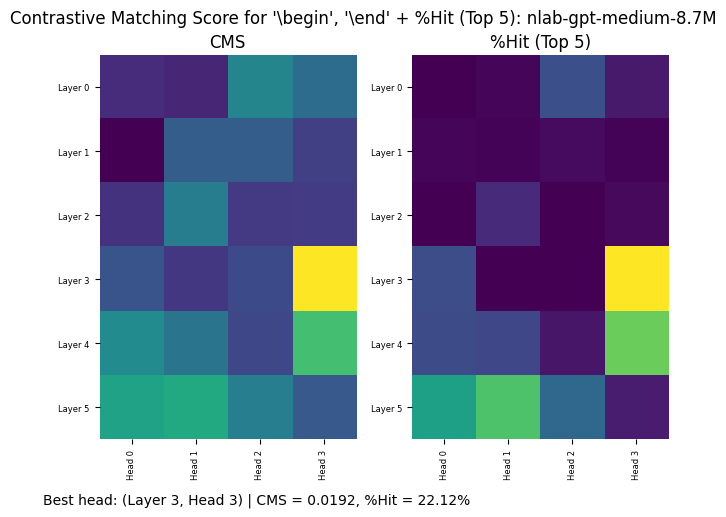

In [6]:
show_cms_hits(run_base, *get_cms_hits(run_base, max_iters=500, top_k=5), top_k=5)

In [7]:
import pathlib

import matplotlib.colors as mcolors
import tqdm

CHECKPOINTS = "../runs/nlab-gpt-medium-8.7M-eb4543e4"

checkpoints = list(pathlib.Path(CHECKPOINTS).rglob("*.pt"))

steps = []

cms_global = np.zeros(
    (
        len(checkpoints),
        run_base.config.num_hidden_layers,
        run_base.config.num_attention_heads,
    ),
    dtype=np.float64,
)

for i, checkpoint in tqdm.notebook.tqdm(
    enumerate(checkpoints),
    desc="Processing",
    total=len(checkpoints),
    unit="checkpoints",
):
    path = str(checkpoint)
    # Skip the final checkpoint
    if path.endswith("-[final].pt"):
        continue
    run = train.Run.from_file(path)

    steps.append(run.global_step)
    # ((L, H), (L, H))
    cms, _ = get_cms_hits(run, max_iters=30, top_k=5, no_bar=True)
    cms_global[i] = cms

Processing:   0%|          | 0/56 [00:00<?, ?checkpoints/s]

In [8]:
values = np.linspace(0, 5, run_base.config.num_hidden_layers)
norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())
cmap = plt.cm.viridis

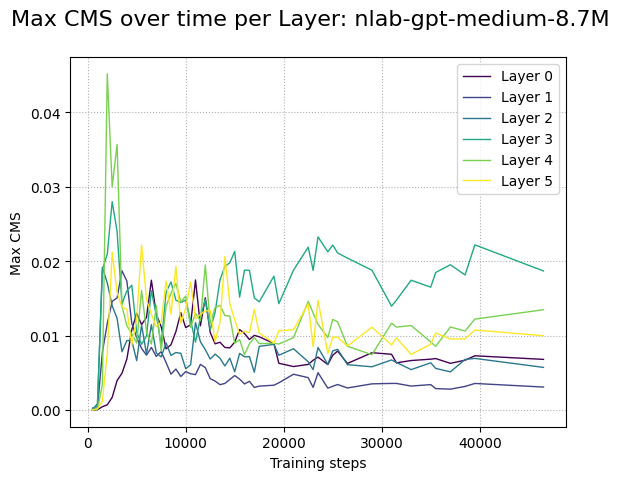

In [9]:
for l in range(run_base.config.num_hidden_layers):
    plt.plot(
        steps,
        cms_global[: len(steps), l, :].max(axis=-1),
        label=f"Layer {l}",
        linewidth=1.0,
        color=cmap(norm(values[l])),
    )

plt.xlabel("Training steps")
plt.ylabel("Max CMS")

plt.suptitle(f"Max CMS over time per Layer: {run.name[:-9]}", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig(f"../assets/max-cms-{run.name[:-9]}.png", dpi=300, bbox_inches="tight")
plt.show()

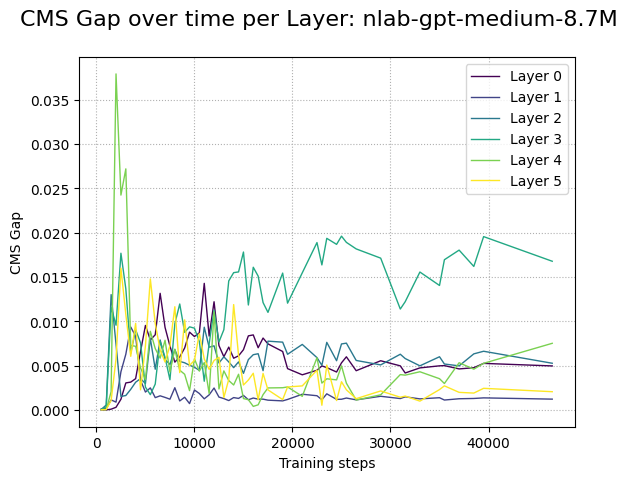

In [10]:
for l, v in enumerate(values):
    plt.plot(
        steps,
        cms_global[: len(steps), l, :].max(axis=-1)
        - np.median(cms_global[: len(steps), l, :], axis=-1),
        label=f"Layer {l}",
        linewidth=1.0,
        color=cmap(norm(v)),
    )

plt.xlabel("Training steps")
plt.ylabel("CMS Gap")

plt.suptitle(f"CMS Gap over time per Layer: {run_base.name[:-9]}", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig(f"../assets/cms-gap-{run_base.name[:-9]}.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
TEXT = [
    "\\begin{proof}\nTrivial\n\\end{proof}",
    "Let $A$ be a category and let $A$ be a category",
    "\\begin{definition}\nGrothendieck\n\\end{definition}",
    "The colimit of $X$ is equivalent to the colimit of $Y$",
]

input_ids = [run_base.tokenizer.encode(t).ids for t in TEXT]
labels = [
    [
        repr(run_base.tokenizer.decode([token]))[1:-1].replace("\\\\", "\\")
        for token in t
    ]
    for t in input_ids
]

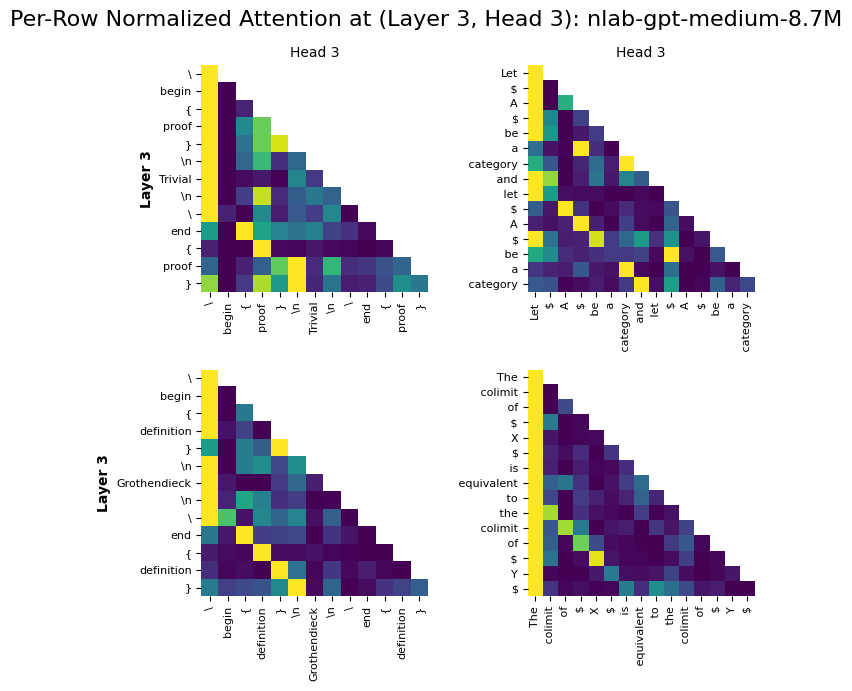

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 7))


for n, i, l in zip(range(len(TEXT)), input_ids, labels):

    ax = axes[n // 2][n % 2]

    def attention_callback(layer, head, attn_weights):
        if layer != 3 or head != 3:
            return
        # We assume there's only one batch
        attn_weights = attn_weights[0, :, :]
        T = attn_weights.shape[0]
        future_mask = np.triu(np.ones((T, T), dtype=bool), k=1)
        A_masked = np.ma.array(attn_weights, mask=future_mask)

        row_min = A_masked.min(axis=1, keepdims=True)
        row_max = A_masked.max(axis=1, keepdims=True)

        den_data = (row_max - row_min).filled(0.0)
        zero_variance_rows = (den_data < 1e-9).flatten()

        den_data[zero_variance_rows] = 1.0
        normalized = (A_masked - row_min) / den_data

        if np.any(zero_variance_rows):
            normalized[zero_variance_rows] = 1.0
        normalized.mask = future_mask

        ax.imshow(
            normalized,
            aspect="equal",
            cmap="viridis",
            interpolation="nearest",
            origin="upper",
        )

        ax.set_xticks(range(len(l)))
        ax.set_yticks(range(len(l)))

        ax.set_xticklabels(l, rotation=90, fontsize=8)
        ax.set_yticklabels(l, fontsize=8)

        if n % 2 == 0:
            ax.set_ylabel(f"Layer {layer}", fontsize=10, fontweight="bold")
        if n // 2 == 0:
            ax.set_title(f"Head {head}", fontsize=10)

        for spine in ax.spines.values():
            spine.set_visible(False)

    with torch.no_grad():
        run_base.model(
            torch.tensor([i], device=device),
            attention_callback=attention_callback,
        )

plt.suptitle(
    f"Per-Row Normalized Attention at (Layer 3, Head 3): {run_base.name[:-9]}",
    fontsize=16,
)
plt.tight_layout()
plt.savefig(
    f"../assets/attention-layer-3-head-3-{run_base.name[:-9]}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()